# 2. Exploratory Data Analysis & Feature Engineering

## 2.1 Load Filtered reviews

In [ ]:
from google.colab import drive
import os
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Define project paths
project_dir = '/content/drive/MyDrive/4awesome/'
data_dir = '/content/drive/MyDrive/4awesome/Data'

reviews = pd.read_csv(os.path.join(data_dir, 'cleaned_reviews.csv'))

Mounted at /content/drive


## 2.2 Importing

In [ ]:
!pip install langdetect

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text analysis
import nltk
from collections import Counter
from wordcloud import WordCloud
import re
from textblob import TextBlob

# Statistical analysis
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer

# Download required NLTK data
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)

# Apply the same preprocessing as in step 1
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from langdetect import detect

# Preprocessing function from step 1
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 2.3 Basic Dataset Overview

In [ ]:
print("\n1. BASIC DATASET OVERVIEW")
print("=" * 50)

# Dataset info
print("Dataset Info:")
print(reviews.info())

# Missing values
print("\nMissing Values:")
print(reviews.isnull().sum())

# Basic statistics
print("\nBasic Statistics:")
print(reviews.describe())


1. BASIC DATASET OVERVIEW
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   business_name        1068 non-null   object
 1   text                 1068 non-null   object
 2   rating               1068 non-null   int64 
 3   rating_category      1068 non-null   object
 4   cleaned_text         1068 non-null   object
 5   text_length          1068 non-null   int64 
 6   cleaned_text_length  1068 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 58.5+ KB
None

Missing Values:
business_name          0
text                   0
rating                 0
rating_category        0
cleaned_text           0
text_length            0
cleaned_text_length    0
dtype: int64

Basic Statistics:
            rating  text_length  cleaned_text_length
count  1068.000000  1068.000000          1068.000000
mean      3.907303    20.5

## 2.4 Target Variable Analysis: rating_category



2. TARGET VARIABLE ANALYSIS
Rating Category Distribution:
rating_category
taste                 323
indoor_atmosphere     283
outdoor_atmosphere    275
menu                  187
Name: count, dtype: int64

Category Percentages:
rating_category
taste                 30.24
indoor_atmosphere     26.50
outdoor_atmosphere    25.75
menu                  17.51
Name: count, dtype: float64


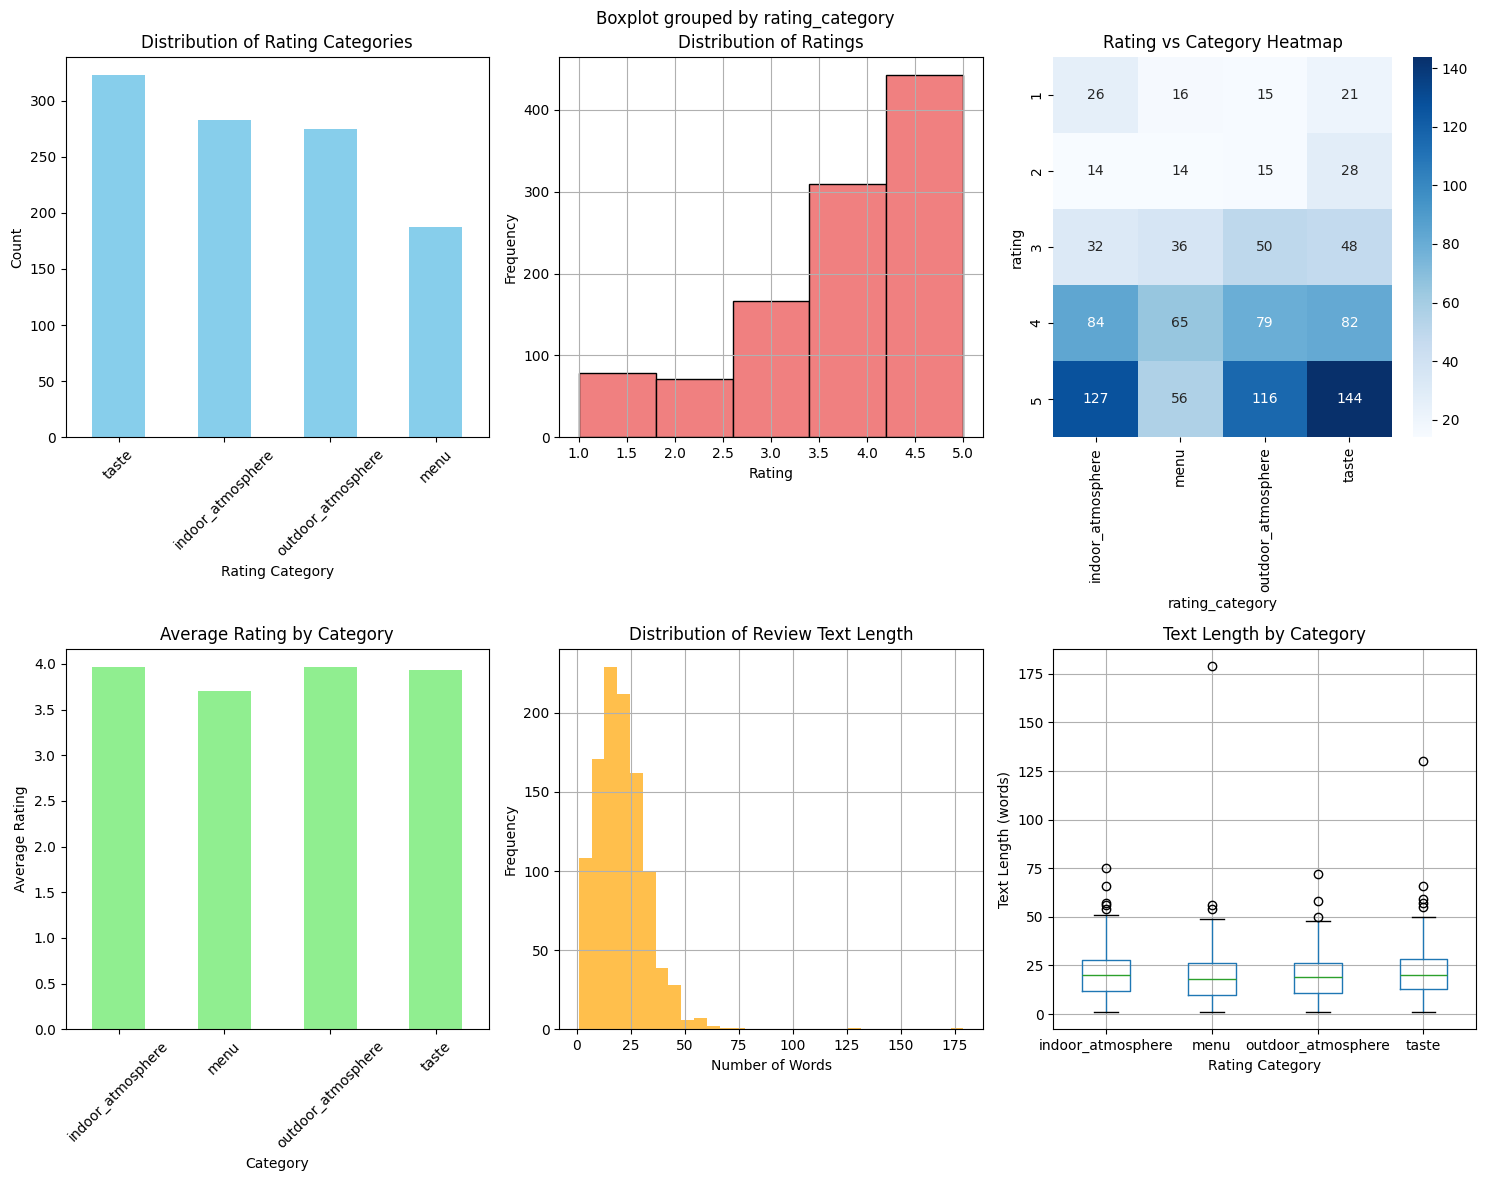


Text Length Statistics by Category:
                    count   mean    std  min  max  median
rating_category                                          
indoor_atmosphere     283  20.99  11.70    1   75    20.0
menu                  187  19.57  16.21    1  179    18.0
outdoor_atmosphere    275  19.09  10.96    1   72    19.0
taste                 323  22.09  12.79    1  130    20.0


In [ ]:
print("\n2. TARGET VARIABLE ANALYSIS")
print("=" * 50)

# Distribution of rating categories
category_counts = reviews['rating_category'].value_counts()
print("Rating Category Distribution:")
print(category_counts)
print(f"\nCategory Percentages:")
print((category_counts / len(reviews) * 100).round(2))

# Visualization setup
plt.figure(figsize=(15, 12))

# Rating category distribution
plt.subplot(2, 3, 1)
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Rating Categories')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Rating distribution
plt.subplot(2, 3, 2)
reviews['rating'].hist(bins=5, color='lightcoral', edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Rating vs Category heatmap
plt.subplot(2, 3, 3)
rating_category_crosstab = pd.crosstab(reviews['rating'], reviews['rating_category'])
sns.heatmap(rating_category_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title('Rating vs Category Heatmap')

# Average rating by category
plt.subplot(2, 3, 4)
avg_rating_by_category = reviews.groupby('rating_category')['rating'].mean()
avg_rating_by_category.plot(kind='bar', color='lightgreen')
plt.title('Average Rating by Category')
plt.xlabel('Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)

# Text length distribution
plt.subplot(2, 3, 5)
reviews['text_length'].hist(bins=30, color='orange', alpha=0.7)
plt.title('Distribution of Review Text Length')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

# Text length by category
plt.subplot(2, 3, 6)
reviews.boxplot(column='text_length', by='rating_category', ax=plt.gca())
plt.title('Text Length by Category')
plt.xlabel('Rating Category')
plt.ylabel('Text Length (words)')

plt.tight_layout()
plt.show()

# Statistical analysis of text length by category
print("\nText Length Statistics by Category:")
text_length_stats = reviews.groupby('rating_category')['text_length'].agg([
    'count', 'mean', 'std', 'min', 'max', 'median'
]).round(2)
print(text_length_stats)

## 2.5 Keyword and Topic Analysis


In [ ]:
print("\n3. KEYWORD AND TOPIC ANALYSIS")
print("=" * 50)

# Most common words by category
def get_top_words(texts, n=10):
    """Get top n words from a collection of texts"""
    all_words = []
    for text in texts:
        if pd.notna(text):
            words = str(text).split()
            all_words.extend(words)
    return Counter(all_words).most_common(n)

print("Top words by category:")
for category in reviews['rating_category'].unique():
    category_texts = reviews[reviews['rating_category'] == category]['cleaned_text']
    top_words = get_top_words(category_texts, 15)
    print(f"\n{category.upper()}:")
    for word, count in top_words:
        print(f"  {word}: {count}")

# TF-IDF analysis to find distinctive words
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(reviews['cleaned_text'].fillna(''))
feature_names = vectorizer.get_feature_names_out()

# Get TF-IDF scores by category
print("\nDistinctive words by category (TF-IDF):")
for i, category in enumerate(reviews['rating_category'].unique()):
    category_mask = reviews['rating_category'] == category
    category_tfidf = tfidf_matrix[category_mask.values].mean(axis=0).A1
    top_indices = category_tfidf.argsort()[-10:][::-1]
    print(f"\n{category.upper()}:")
    for idx in top_indices:
        if category_tfidf[idx] > 0:
            print(f"  {feature_names[idx]}: {category_tfidf[idx]:.3f}")


3. KEYWORD AND TOPIC ANALYSIS
Top words by category:

TASTE:
  place: 53
  price: 45
  service: 42
  taste: 41
  good.: 36
  food: 34
  delicious: 34
  good: 32
  like: 28
  meat: 26
  also: 26
  nice: 23
  definitely: 23
  delicious.: 23
  breakfast: 21

MENU:
  price: 47
  food: 30
  good.: 25
  place: 23
  taste: 21
  good: 17
  service: 14
  recommend: 13
  little: 13
  ate: 12
  really: 12
  also: 12
  came: 12
  delicious.: 12
  pizza: 11

OUTDOOR_ATMOSPHERE:
  place: 55
  taste: 35
  service: 34
  good.: 31
  good: 31
  price: 30
  nice: 27
  food: 25
  delicious: 23
  also: 20
  ate: 20
  good;: 20
  like: 20
  really: 18
  little: 18

INDOOR_ATMOSPHERE:
  place: 51
  price: 38
  food: 31
  service: 30
  taste: 29
  good.: 28
  delicious: 27
  good: 25
  nice: 23
  restaurant: 19
  one: 18
  nice.: 18
  staff: 17
  employee: 17
  ambiance: 16

Distinctive words by category (TF-IDF):

TASTE:
  delicious: 0.079
  good: 0.072
  place: 0.064
  taste: 0.064
  nice: 0.049
  food: 0.

## 2.6 Spam/Advertising Detection



4. POTENTIAL SPAM/ADVERTISING DETECTION

Spam Classification Summary:
spam_label
Genuine        1046
Suspicious       20
Likely Spam       2
Name: count, dtype: int64

Spam Classification Percentages:
spam_label
Genuine        97.9
Suspicious      1.9
Likely Spam     0.2
Name: proportion, dtype: float64

Spam EDA & Visualization


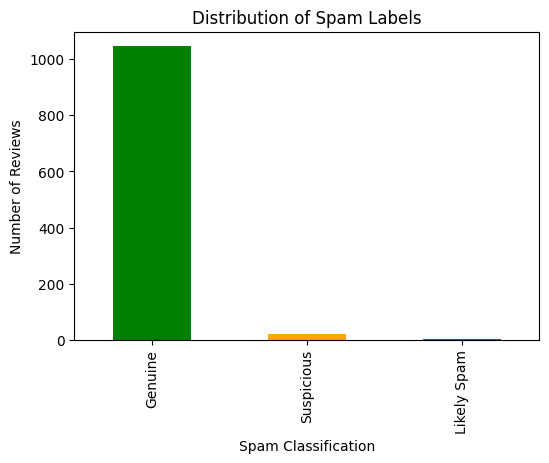

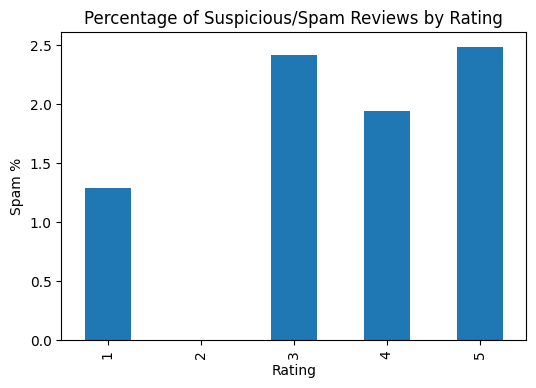

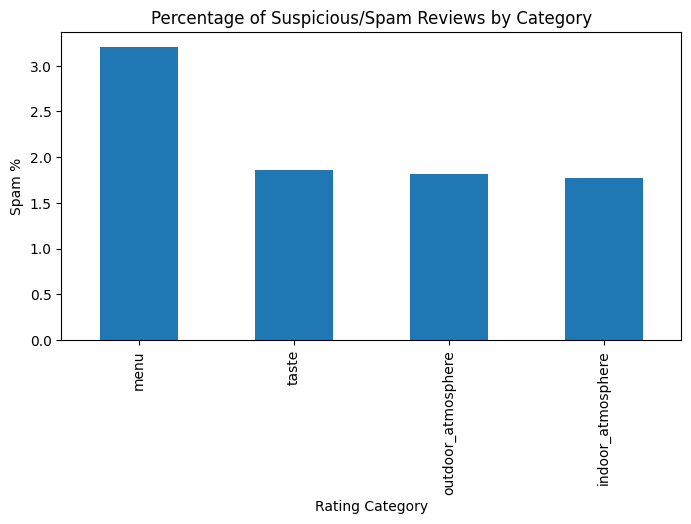

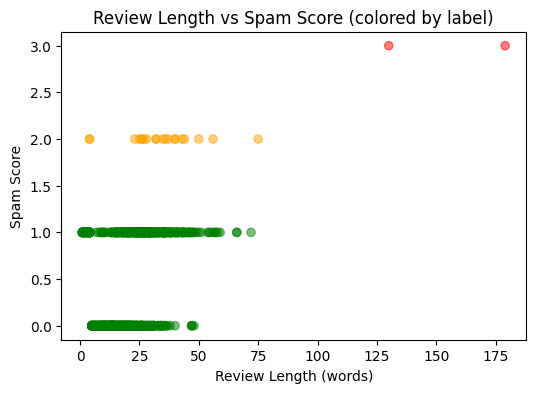

In [ ]:
print("\n4. POTENTIAL SPAM/ADVERTISING DETECTION")
print("=" * 50)

import re
from collections import Counter
import matplotlib.pyplot as plt


# Spam scoring function
def check_spam_content(text):
    if pd.isna(text):
        return 0
    text = str(text).lower()
    score = 0

    # Promotional keywords
    promotional_keywords = [
        'visit', 'website', 'contact', 'call now', 'email', 'promotion', 'discount',
        'special offer', 'deal', 'sale', 'buy', 'order now', 'delivery',
        'follow us', 'like & share', 'sign up', 'subscribe', 'exclusive',
        'limited time', 'hurry', 'act fast', 'guaranteed', 'cheap', 'best price',
        'don’t miss', 'click here', '5 stars', 'must try', 'highly recommended',
        'amazing service', 'perfect place', 'top rated', 'no.1 restaurant'
    ]
    score += sum(1 for kw in promotional_keywords if kw in text)

    # URL / Email / Phone
    if re.search(r"http[s]?://|www\.", text): score += 2
    if re.search(r"\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b", text): score += 2
    if re.search(r"\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b", text): score += 2

    # Repeated words
    words = re.findall(r'\w+', text)
    counts = Counter(words)
    if any(c >= 3 for c in counts.values()):
        score += 1

    # Too short & generic review
    if len(words) < 5:
        score += 1

    # Too long (could be copy-paste promotional text)
    if len(words) > 100:
        score += 1

    # Excessive punctuation or shouting
    if re.search(r"!!!+|\?\?\?+|\$\$\$+", text): score += 1
    if text.isupper() and len(text) > 20: score += 1

    return score

reviews['spam_score'] = reviews['text'].apply(check_spam_content)

def classify_review(score):
    if score <= 1:
        return "Genuine"
    elif score == 2:
        return "Suspicious"
    else:  # score >= 3
        return "Likely Spam"

reviews['spam_label'] = reviews['spam_score'].apply(classify_review)

print("\nSpam Classification Summary:")
print(reviews['spam_label'].value_counts())

print("\nSpam Classification Percentages:")
print((reviews['spam_label'].value_counts(normalize=True) * 100).round(1))

# EDA & Visualization
print("\nSpam EDA & Visualization")

# 1. Distribution of spam labels
plt.figure(figsize=(6,4))
reviews['spam_label'].value_counts().plot(kind='bar', color=['green','orange','red'])
plt.title("Distribution of Spam Labels")
plt.xlabel("Spam Classification")
plt.ylabel("Number of Reviews")
plt.show()

# 2. Spam label percentage by rating (1–5 stars)
spam_by_rating = reviews.groupby('rating')['spam_label'].apply(lambda x: (x != "Genuine").mean() * 100)
plt.figure(figsize=(6,4))
spam_by_rating.plot(kind='bar')
plt.title("Percentage of Suspicious/Spam Reviews by Rating")
plt.xlabel("Rating")
plt.ylabel("Spam %")
plt.show()

# 3. Spam label percentage by rating category (taste, menu, etc.)
spam_by_category = reviews.groupby('rating_category')['spam_label'].apply(lambda x: (x != "Genuine").mean() * 100).sort_values(ascending=False)
plt.figure(figsize=(8,4))
spam_by_category.plot(kind='bar')
plt.title("Percentage of Suspicious/Spam Reviews by Category")
plt.xlabel("Rating Category")
plt.ylabel("Spam %")
plt.show()

# 4. Review length vs spam label
reviews['review_length'] = reviews['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6,4))
colors = reviews['spam_label'].map({'Genuine':'green','Suspicious':'orange','Likely Spam':'red'})
plt.scatter(reviews['review_length'], reviews['spam_score'], c=colors, alpha=0.5)
plt.title("Review Length vs Spam Score (colored by label)")
plt.xlabel("Review Length (words)")
plt.ylabel("Spam Score")
plt.show()


## 2.7 Sentiment Analysis


5. SENTIMENT ANALYSIS
Sentiment Analysis Results:
Average sentiment polarity: 0.323
Average sentiment subjectivity: 0.643

Sentiment by Category:
                    sentiment_polarity  sentiment_subjectivity
rating_category                                               
indoor_atmosphere                0.327                   0.650
menu                             0.243                   0.607
outdoor_atmosphere               0.372                   0.647
taste                            0.323                   0.656

Correlation between sentiment and rating: 0.557


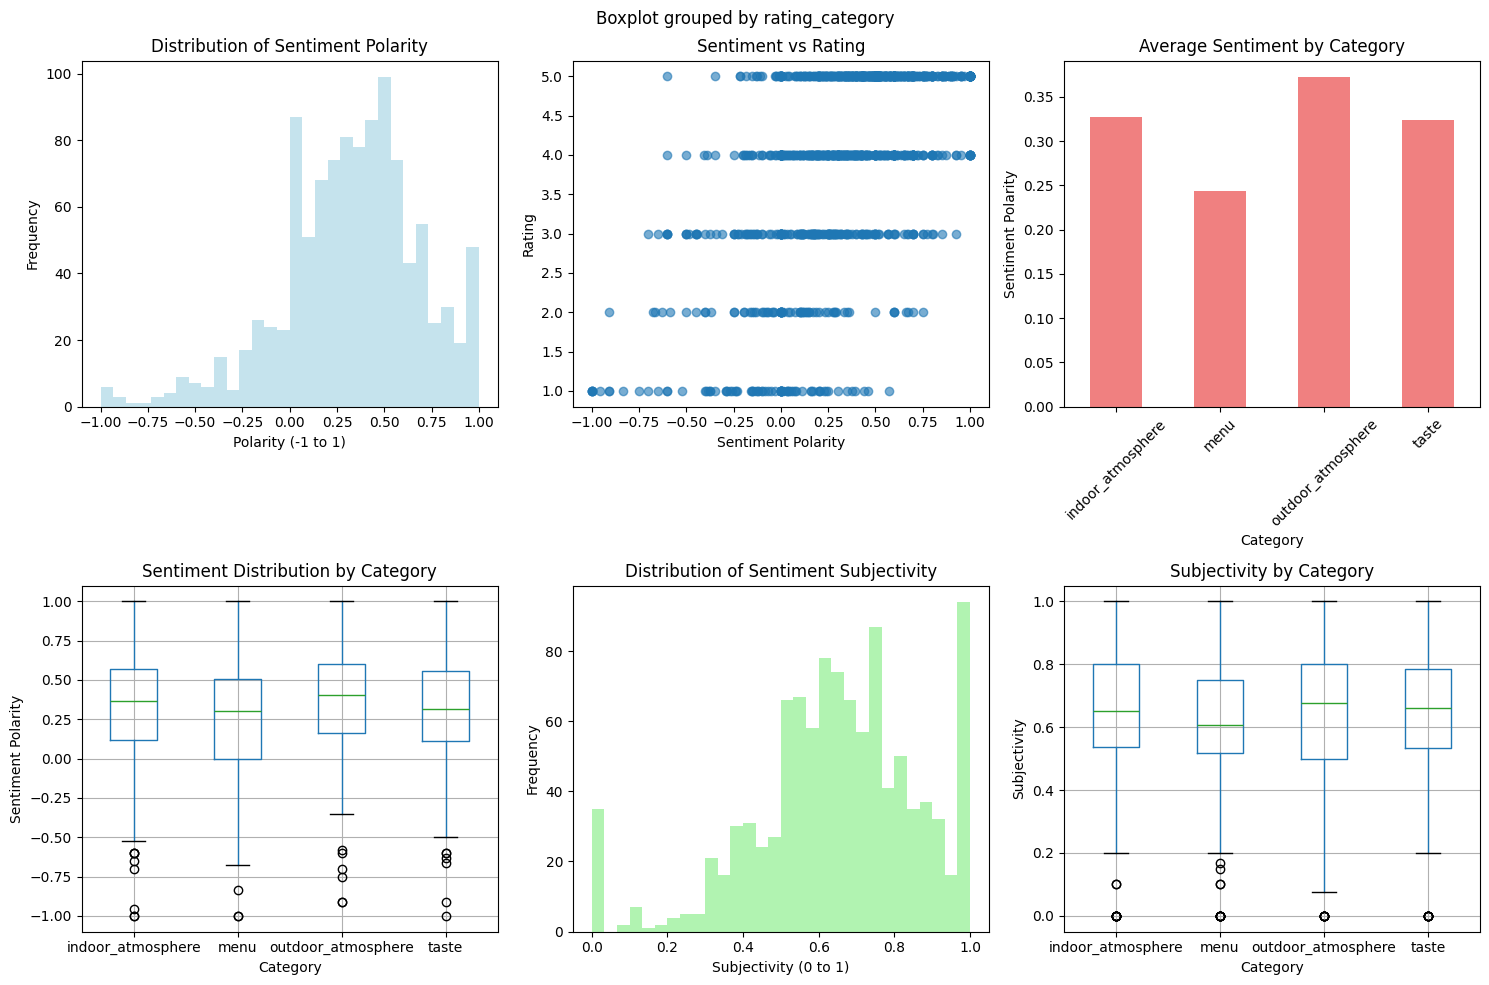

,business_name,text,rating,rating_category,cleaned_text,text_length,cleaned_text_length,spam_score,spam_label,review_length,sentiment_polarity,sentiment_subjectivity
0,Haci'nin Yeri - Yigit Lokantasi,We went to Marmaris with my wife for a holiday...,5,taste,went marmaris wife holiday. chose restaurant p...,130,61,3,Likely Spam,130,0.026190,0.700000
1,Haci'nin Yeri - Yigit Lokantasi,During my holiday in Marmaris we ate here to f...,4,menu,holiday marmaris ate fit food. really good foo...,179,83,3,Likely Spam,179,0.164583,0.660417
2,Haci'nin Yeri - Yigit Lokantasi,Prices are very affordable. The menu in the ph...,3,outdoor_atmosphere,price affordable. menu photo cost 108 liras. w...,31,19,0,Genuine,31,0.275000,0.700000
3,Haci'nin Yeri - Yigit Lokantasi,Turkey's cheapest artisan restaurant and its f...,5,indoor_atmosphere,turkey's cheapest artisan restaurant food deli...,9,6,1,Genuine,9,1.000000,1.000000
4,Haci'nin Yeri - Yigit Lokantasi,I don't know what you will look for in terms o...,3,menu,know look term price performance point; taste;...,31,15,0,Genuine,31,0.000000,0.100000


In [ ]:
print("\n5. SENTIMENT ANALYSIS")
print("=" * 50)

# Sentiment analysis using TextBlob
def get_sentiment(text):
    """Get sentiment polarity and subjectivity"""
    if pd.isna(text):
        return 0, 0
    blob = TextBlob(str(text))
    return blob.sentiment.polarity, blob.sentiment.subjectivity

sentiment_data = reviews['text'].apply(get_sentiment)
reviews['sentiment_polarity'] = [x[0] for x in sentiment_data]
reviews['sentiment_subjectivity'] = [x[1] for x in sentiment_data]

# Sentiment statistics
print("Sentiment Analysis Results:")
print(f"Average sentiment polarity: {reviews['sentiment_polarity'].mean():.3f}")
print(f"Average sentiment subjectivity: {reviews['sentiment_subjectivity'].mean():.3f}")

# Sentiment by rating category
sentiment_by_category = reviews.groupby('rating_category')[['sentiment_polarity', 'sentiment_subjectivity']].mean()
print("\nSentiment by Category:")
print(sentiment_by_category.round(3))

# Sentiment vs actual rating correlation
correlation = reviews['sentiment_polarity'].corr(reviews['rating'])
print(f"\nCorrelation between sentiment and rating: {correlation:.3f}")

# Visualization
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(reviews['sentiment_polarity'], bins=30, color='lightblue', alpha=0.7)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Polarity (-1 to 1)')
plt.ylabel('Frequency')

plt.subplot(2, 3, 2)
plt.scatter(reviews['sentiment_polarity'], reviews['rating'], alpha=0.6)
plt.title('Sentiment vs Rating')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Rating')

plt.subplot(2, 3, 3)
sentiment_by_category['sentiment_polarity'].plot(kind='bar', color='lightcoral')
plt.title('Average Sentiment by Category')
plt.xlabel('Category')
plt.ylabel('Sentiment Polarity')
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
reviews.boxplot(column='sentiment_polarity', by='rating_category', ax=plt.gca())
plt.title('Sentiment Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Sentiment Polarity')

plt.subplot(2, 3, 5)
plt.hist(reviews['sentiment_subjectivity'], bins=30, color='lightgreen', alpha=0.7)
plt.title('Distribution of Sentiment Subjectivity')
plt.xlabel('Subjectivity (0 to 1)')
plt.ylabel('Frequency')

plt.subplot(2, 3, 6)
reviews.boxplot(column='sentiment_subjectivity', by='rating_category', ax=plt.gca())
plt.title('Subjectivity by Category')
plt.xlabel('Category')
plt.ylabel('Subjectivity')

plt.tight_layout()
plt.show()

reviews.head()

## 2.8 Correlation Analysis


10. CORRELATION ANALYSIS


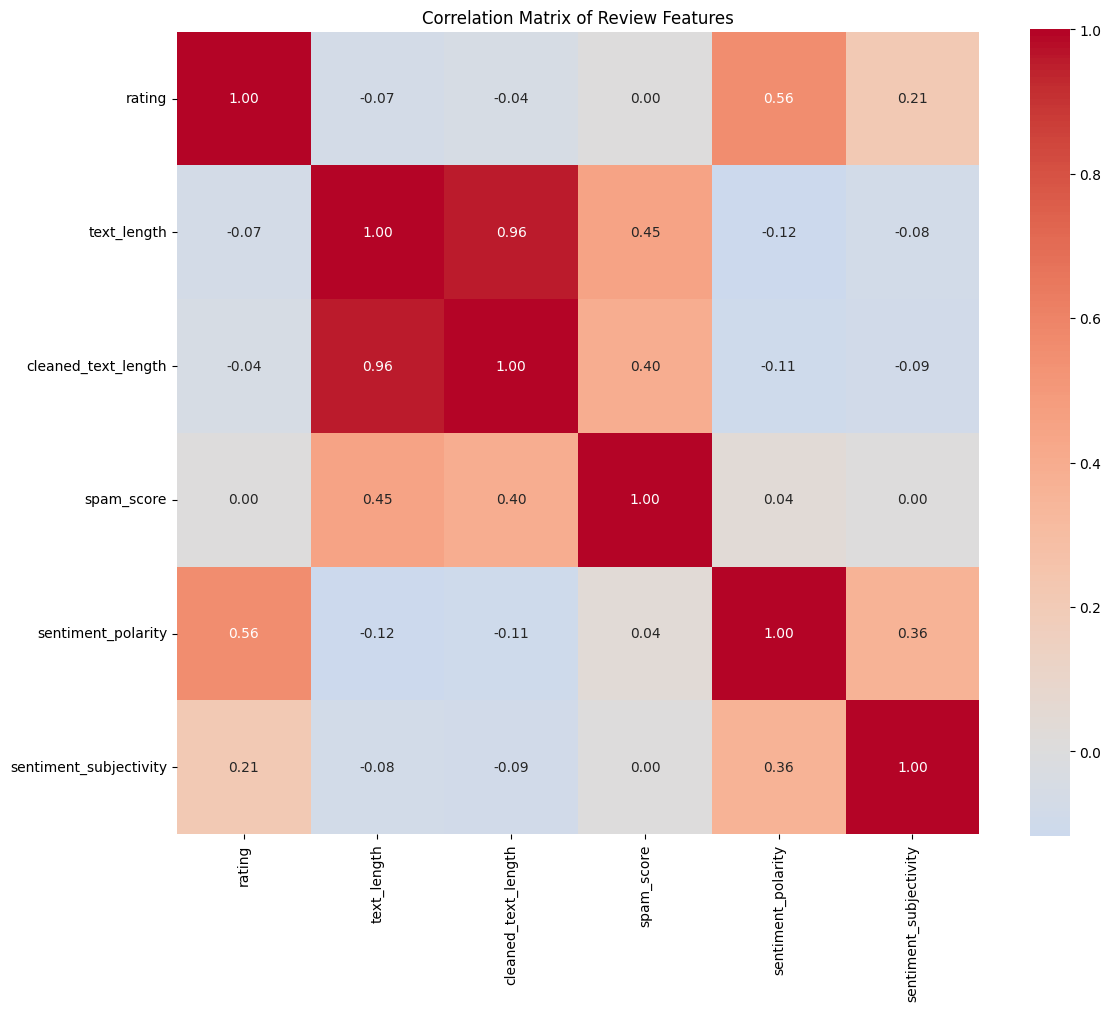

Key correlations with rating:
sentiment_polarity: 0.557
sentiment_subjectivity: 0.215


In [ ]:
print("\n10. CORRELATION ANALYSIS")
print("=" * 50)

# Select numeric features for correlation analysis
numeric_features = [
    'rating', 'text_length', 'cleaned_text_length',
    'spam_score',
    'sentiment_polarity', 'sentiment_subjectivity'
]

correlation_matrix = reviews[numeric_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f')
plt.title('Correlation Matrix of Review Features')
plt.tight_layout()
plt.show()

print("Key correlations with rating:")
rating_correlations = correlation_matrix['rating'].sort_values(ascending=False)
for feature, corr in rating_correlations.items():
    if feature != 'rating' and abs(corr) > 0.1:
        print(f"{feature}: {corr:.3f}")

In [ ]:
reviews.to_csv("/content/drive/MyDrive/4awesome/Data/reviews_after_eda.csv", index=False)

#3. Feature Engineering

# 3.1 Basic Lexical / Numeric Features

In [ ]:
# Average word length: Reviews with very short “words” or many filler words might indicate low-quality content.
# Long words may indicate more formal or descriptive writing.
reviews["char_count"] = reviews["cleaned_text"].apply(len)
reviews["avg_word_len"] = reviews["char_count"] / (reviews["cleaned_text_length"] + 1)

# Lexical/spam features
# Low ratio → repetitive or spammy content (e.g., “good good good good”).
# High ratio → more descriptive, possibly higher-quality review.
reviews["unique_word_ratio"] = reviews["cleaned_text"].apply(
    lambda x: len(set(str(x).split())) / (len(str(x).split()) + 1)
)


reviews.head()

#3.2 Sentiment Features
Useful to detect rants, complaints, or promotional reviews with overly positive/negative sentiment.

VADER Sentiment: Optimized for short-form text found on online review

In [ ]:
# VADER sentiment
reviews["vader_pos"] = reviews["text"].apply(lambda x: sia.polarity_scores(str(x))["pos"])
reviews["vader_neg"] = reviews["text"].apply(lambda x: sia.polarity_scores(str(x))["neg"])
reviews["vader_neu"] = reviews["text"].apply(lambda x: sia.polarity_scores(str(x))["neu"])
reviews["vader_compound"] = reviews["text"].apply(lambda x: sia.polarity_scores(str(x))["compound"])

#3.3 Encode rating category


In [ ]:
# Encode rating_category into numeric labels
le = LabelEncoder()
reviews["rating_category_encoded"] = le.fit_transform(reviews["rating_category"])

print("Classes:", le.classes_)  # just to see mapping


#3.4 Export Data to CSV

In [ ]:
reviews.to_csv("/content/drive/MyDrive/4awesome/Data/reviews_with_features.csv", index=False)

#Inspecting reviews_with_features dataset


In [ ]:
# Load exported CSV to check
df_check = pd.read_csv(os.path.join(data_dir,'reviews_with_features.csv'))

# Quick inspection
print(df_check.head())
print(df_check.columns)
print(df_check.shape)